# Simulation

## Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import SelectPath_RT,Delay_RT,FO_RT

import package_LAB2
from package_LAB2 import SelectPath_RT,Delay_RT,Leadlag,PID_RT, IMC_TUNNING

from importlib import reload
package_DBR=reload(package_DBR)
package_LAB2=reload(package_LAB2)

## Paramètres expériences

In [2]:
# Parameters for input-output dynamics
Kp = 0.519824867356309
T1p = 130.72860133396208
T2p = 5.242159493885901e-07
thetap = 6.12502244580564

# Parameters for disturbance dynamics
Kd = 0.45188195989398117
T1d = 93.79714286404828
T2d = 47.79759461272312
thetad = 2.0000001555147313

## Simulation parameters

In [3]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 0.6
#Kc,Ti,Td = IMC_TUNNING(Kp,T1p,T2p,thetap,gamma,'SOPDT')
#print(Kc,Ti,Td)
Kc,Ti,Td = 3, 136, 9
alpha = 1
MVMin = 0
MVMax = 100

## Scenario

In [4]:
# # OLP + no FF
# ManPath = {0: True, TSim: True}               
# MVManPath = {0: MV0 , Tsim : MV0}             
# SPPath = {0: PV0, TSim: PV0}    #HERE              
# DVPath = {0: 50, 1000: 60, TSim: 60}      
# ActivateFF = False
# ManFF = True

#OLP + FF             
ManPath = {0: True, TSim: True}               
MVManPath = {0: MV0, TSim: MV0}               
SPPath = {0: PV0, TSim: PV0}                  
DVPath = {0: 50, 1000: 60,  TSim: 60}     
ActivateFF = True
ManFF = True

          
# # CLP + no FF
# ManPath = {0: True, 750: False,  TSim: False}  
# MVManPath = {0: MV0+10, TSim: MV0}       #HERE          
# SPPath = {0: PV0,800:PV0-10, TSim: PV0-10}      
# DVPath = {0: DV0,1500: DV0+10, TSim: DV0+10}    
# ActivateFF = True
# ManFF= False
""""
# #CLP+FF
title = "CLP_FF"  
ManPath = {0: True, 750: False,  TSim: False}   
MVManPath = {0: MV0, TSim: MV0}          
SPPath = {0: PV0,800:PV0-10, TSim: PV0-10}     
DVPath = {0: DV0,1500: DV0+10, TSim: DV0+10}    
ManFF= False
"""

## Plots

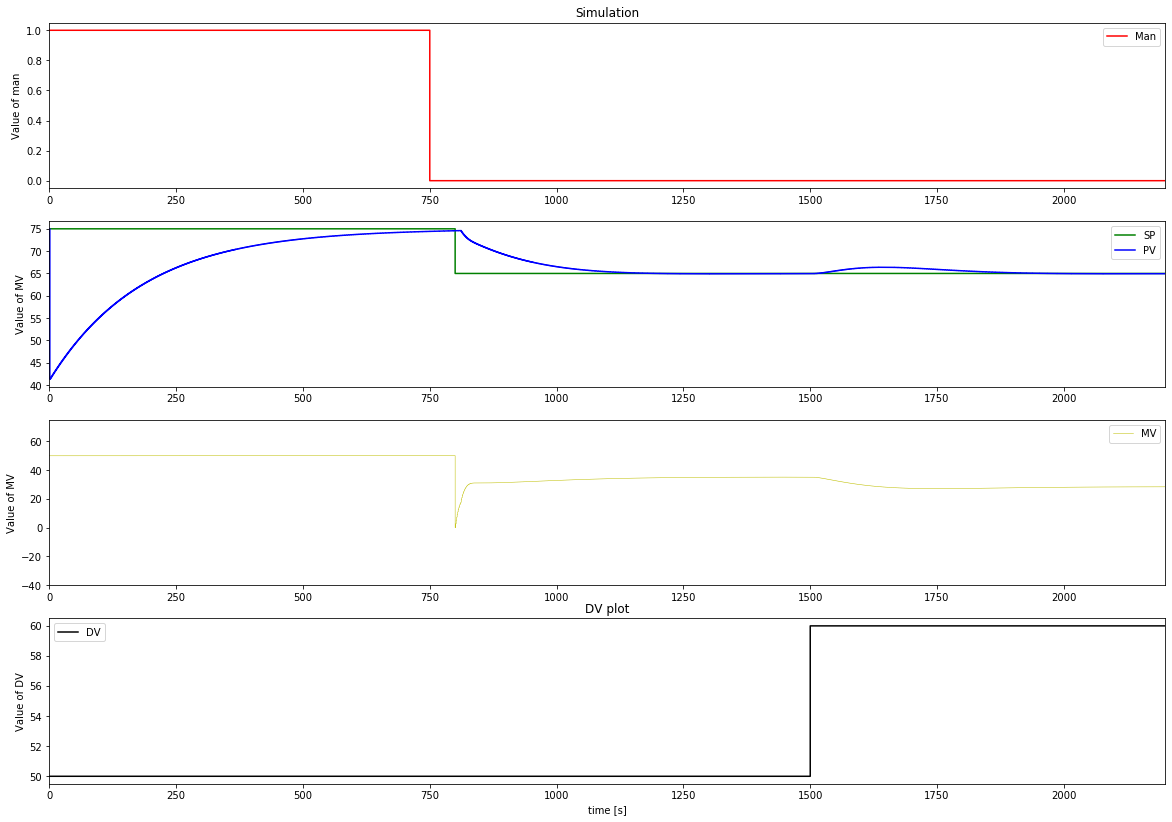

In [5]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []

MVFF = []
MVMan=[]
Man = []

MVFFDelay = []
MVFFLL = []

MVDelayp = []
MVDelayd = []

PV1p = []   #use in case of FF activation
PV2p = []

PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # sp & dv
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    Leadlag(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    Leadlag(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    # PID mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # pid
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)

    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)
        
plt.figure(figsize = (20,14))

plt.subplot(4,1,1)
plt.step(t,Man,'r-',label='Man',where='post')
plt.ylabel('Value of man')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.title('Simulation')

plt.subplot(4,1,2)
plt.step(t,SP,'g-',label='SP',where='post')
plt.step(t,PV[:-1],'b-',label='PV',where='post')
plt.ylabel('Value of MV')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,3)
#plt.step(t,MVP,'r-',label='MVP',where='post')
#plt.step(t,MVI,'y-',label='MVI',where='post')
#plt.step(t,MVD,'g-',label='MVD',where='post')
plt.step(t,MV,'y-',linewidth=0.5,label='MV',where='post')
#plt.step(t,MVFF,'c-',label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.ylim([-40, 75])

plt.subplot(4,1,4)
plt.step(t,DV,'black',label='DV',where='post')
plt.ylabel('Value of DV')
plt.title('DV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.xlabel('time [s]')
plt.show()